In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from PIL import Image
from torch.nn.functional import sigmoid
from torch.utils.data import random_split
from torchvision.models.segmentation import FCN_ResNet50_Weights, fcn_resnet50
from torchvision.transforms.functional import to_pil_image, to_tensor
from tqdm import tqdm

from map_generation.masks.mask_dataset import SegmentationDataset
from map_generation.masks.model import SegmentationModel, SegmentationModule

In [2]:
weights = FCN_ResNet50_Weights.DEFAULT
fcn = fcn_resnet50(weights=weights)
model = SegmentationModule.load_from_checkpoint("model/segmentation_model.ckpt", segmentation_model=SegmentationModel(fcn, 21))

In [7]:
ds = load_dataset("mprzymus/osm_tiles_large")
ds = ds["train"].select_columns("image")
ds

Found cached dataset parquet (/home/marcin/.cache/huggingface/datasets/mprzymus___parquet/mprzymus--osm_tiles_large-956ebe469af8d4e5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image'],
    num_rows: 135556
})

In [4]:
def show_result(img, model):
    plt.figure(figsize=(20,10))
    model_out = model.model(img[0].unsqueeze(0).cuda())
    preds = sigmoid(model_out)
    for i, image in enumerate([img[0], img[1], (preds[0] > 0.5).float()]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(image.permute(1, 2, 0).cpu(), cmap="gray")
    plt.show()



In [46]:

RASTER_PATH = Path("../data/tiles")

segmentation_ds = SegmentationDataset(RASTER_PATH, root_contrain_cities=True)
train_ds, test_ds = random_split(
    segmentation_ds, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)

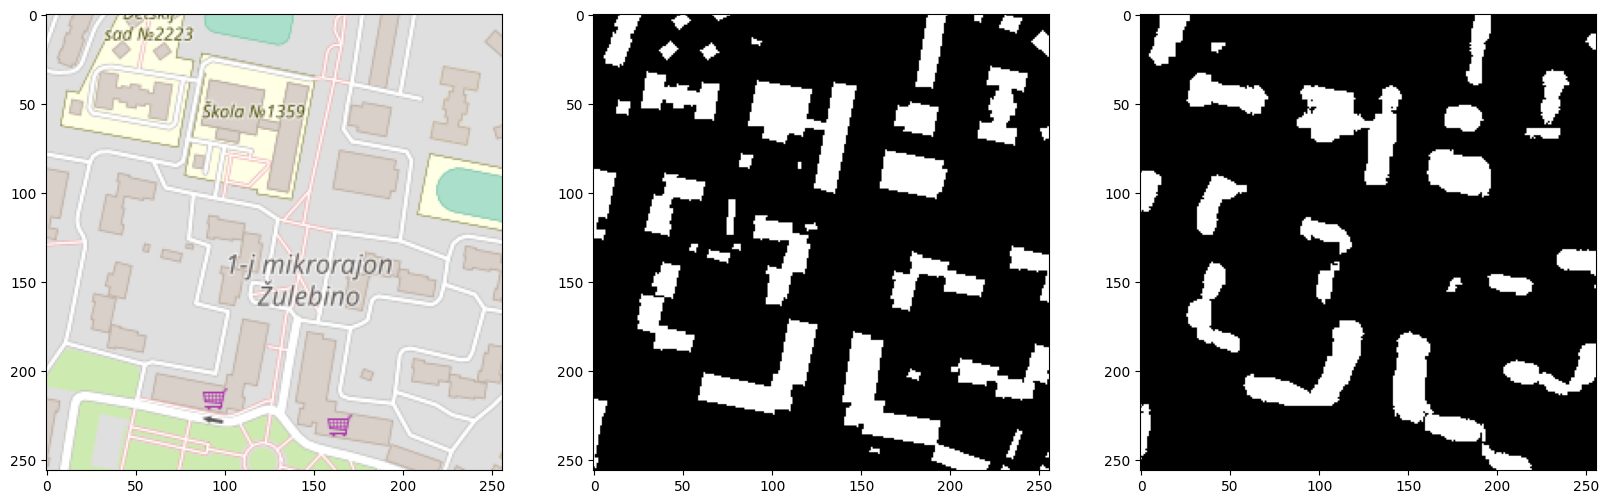

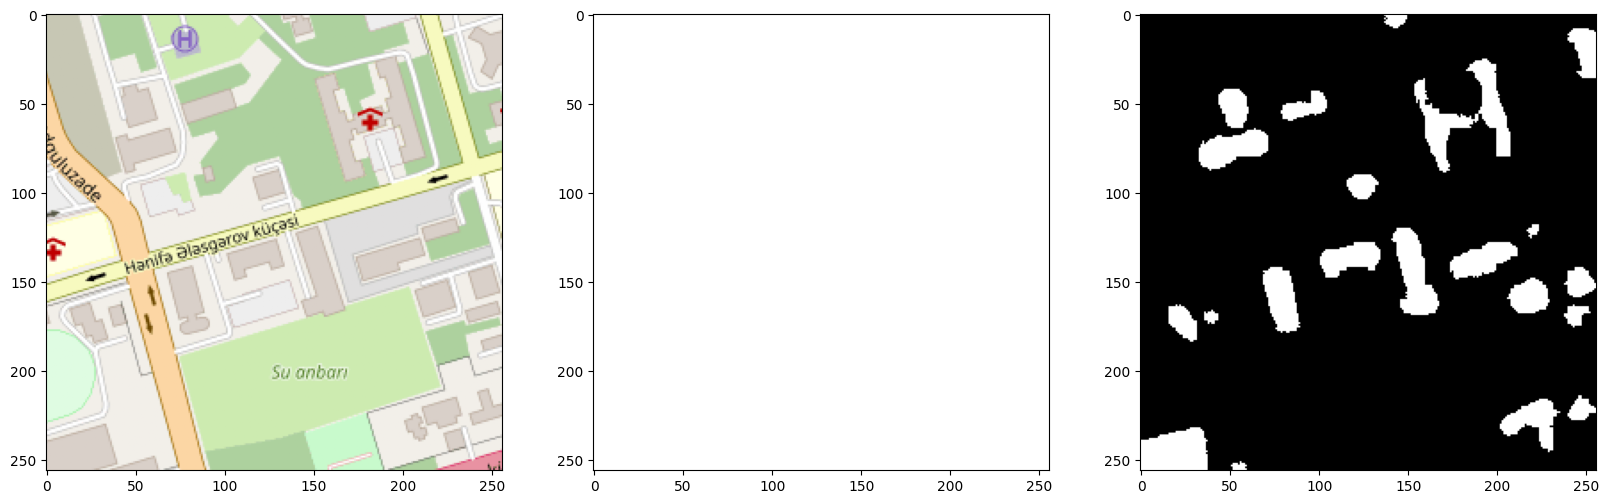

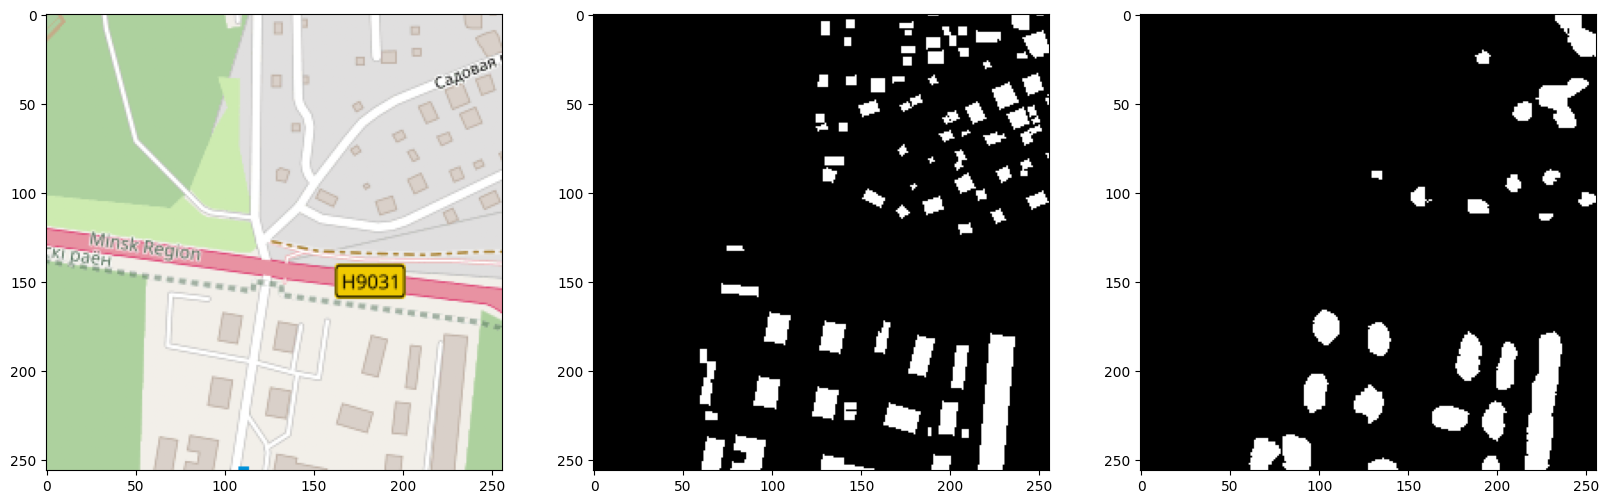

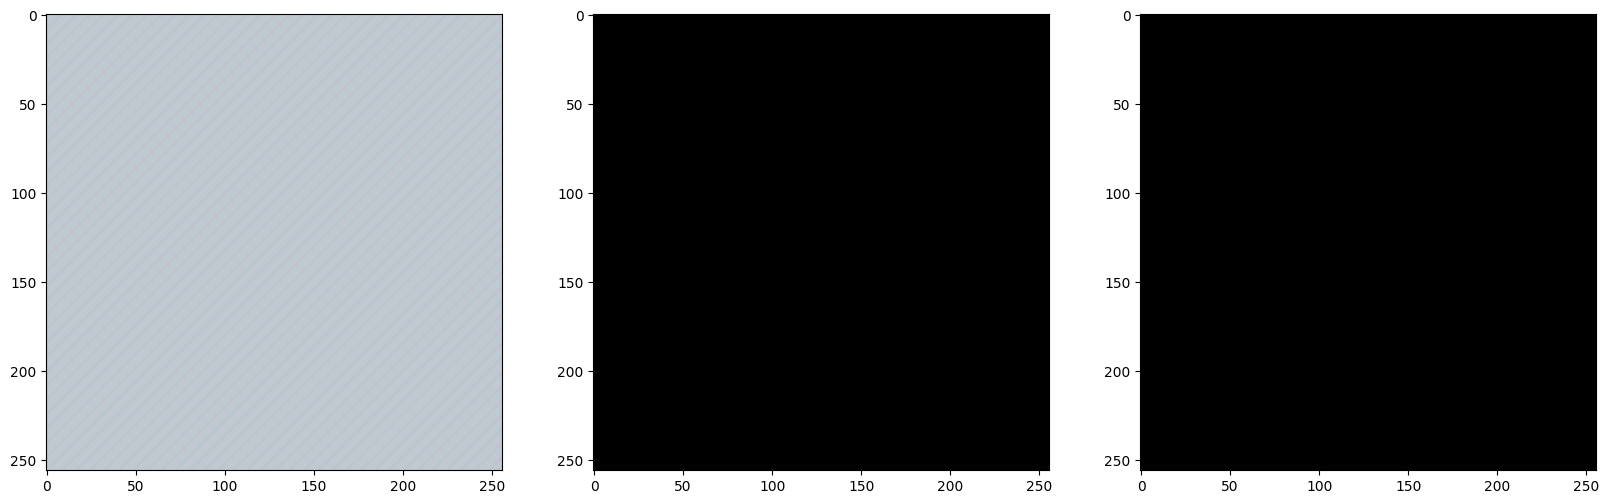

In [48]:

show_result(test_ds[2001], model)
img_ds = to_tensor(ds[2001]["image"].convert("RGB"))
show_result([img_ds, torch.ones_like(img_ds)], model)
show_result(test_ds[64], model)
show_result(test_ds[202], model)

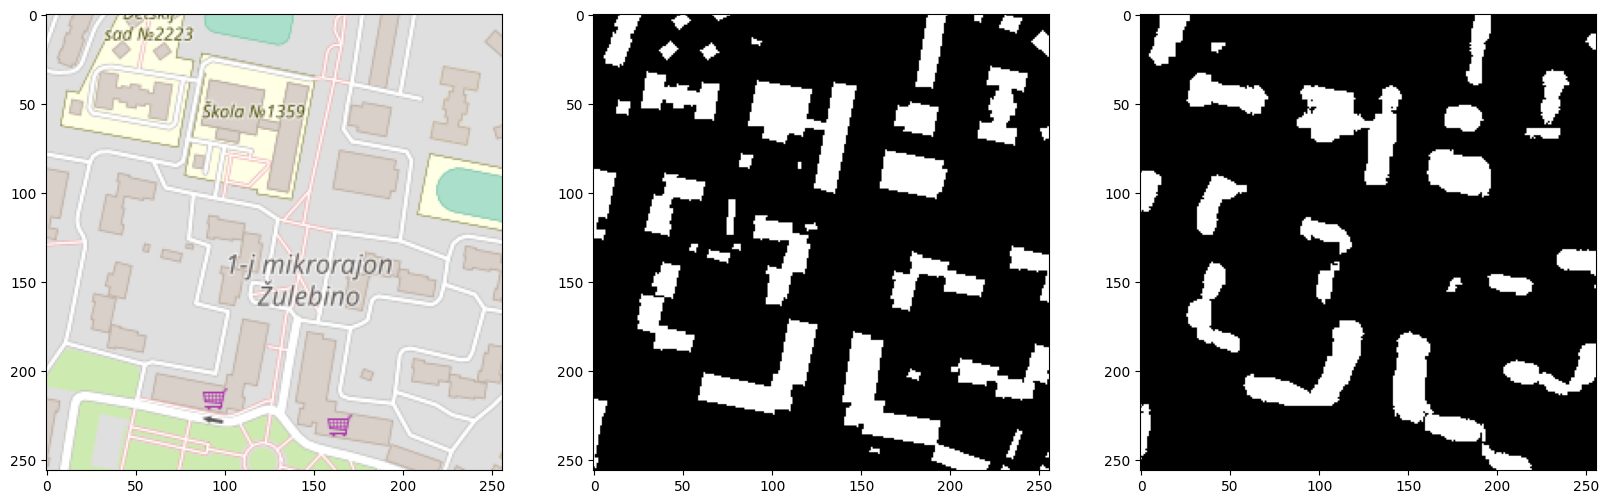

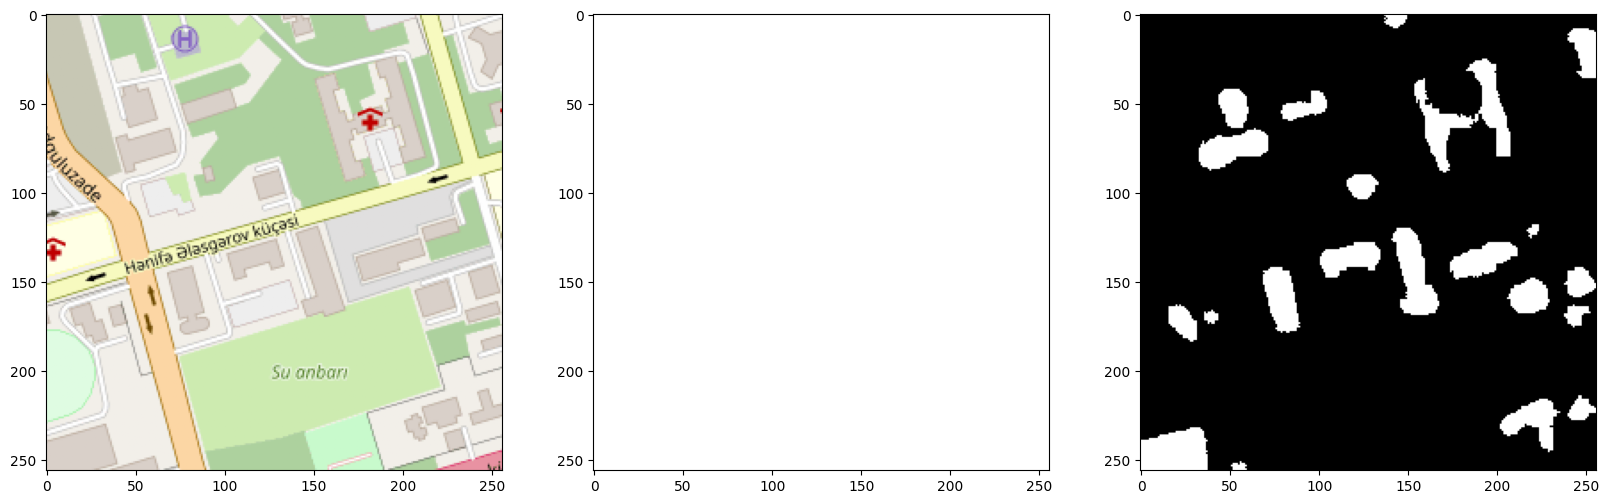

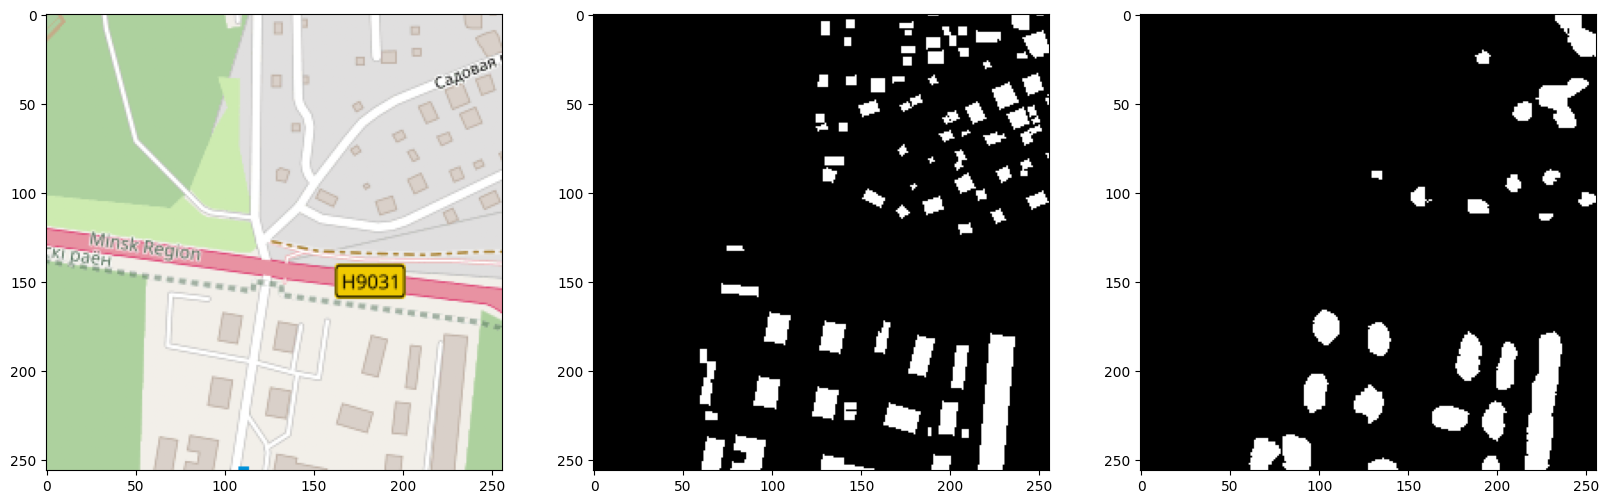

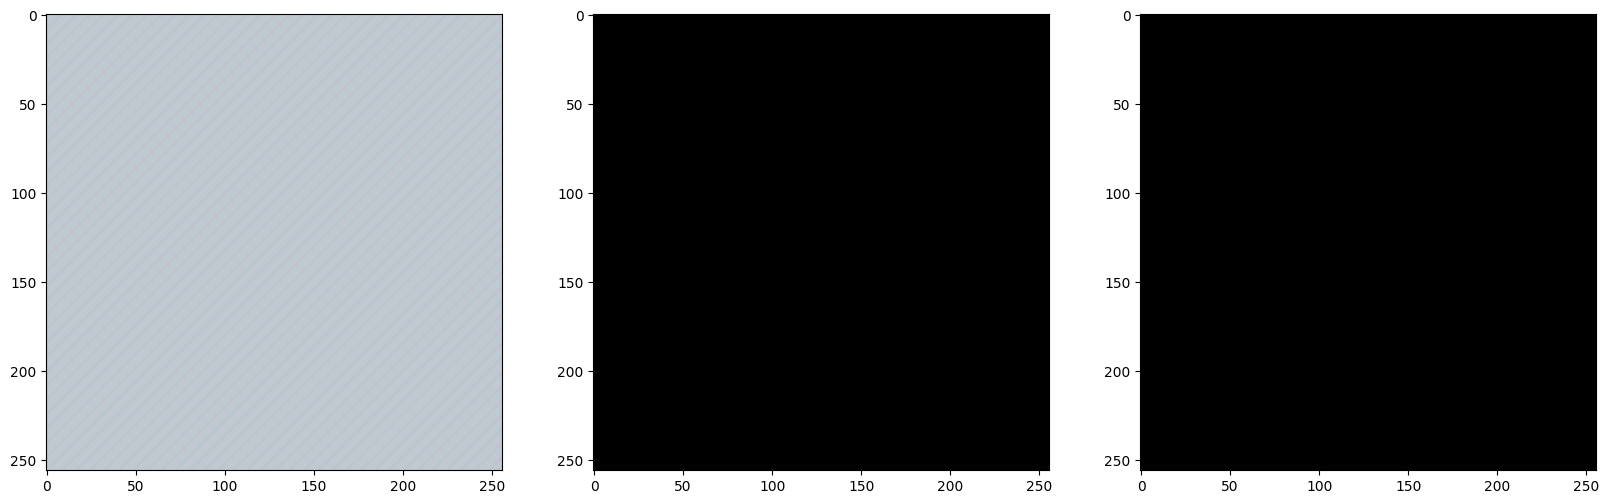

In [53]:
from map_generation.masks.model import Unet

nn = Unet([16, 32, 64, 128, 256], 1)
model = SegmentationModule.load_from_checkpoint("model/segmentation_unet.ckpt", segmentation_model=SegmentationModel(nn, None))

show_result(test_ds[2001], model)
img_ds = to_tensor(ds[2001]["image"].convert("RGB"))
show_result([img_ds, torch.ones_like(img_ds)], model)
show_result(test_ds[64], model)
show_result(test_ds[202], model)

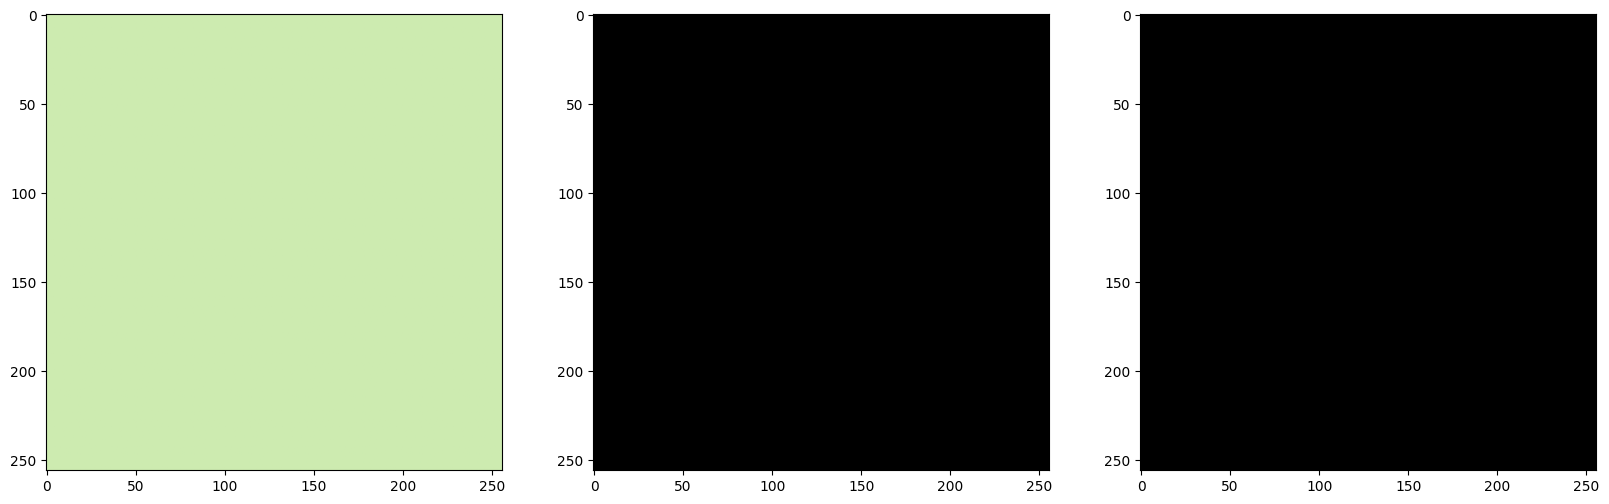

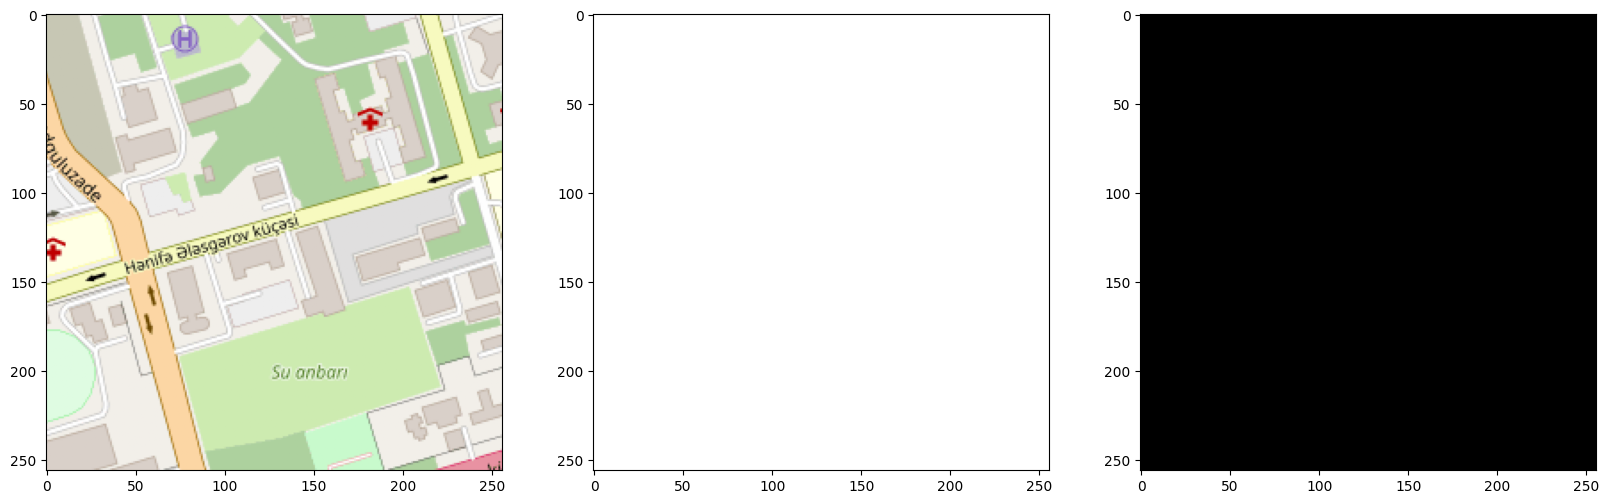

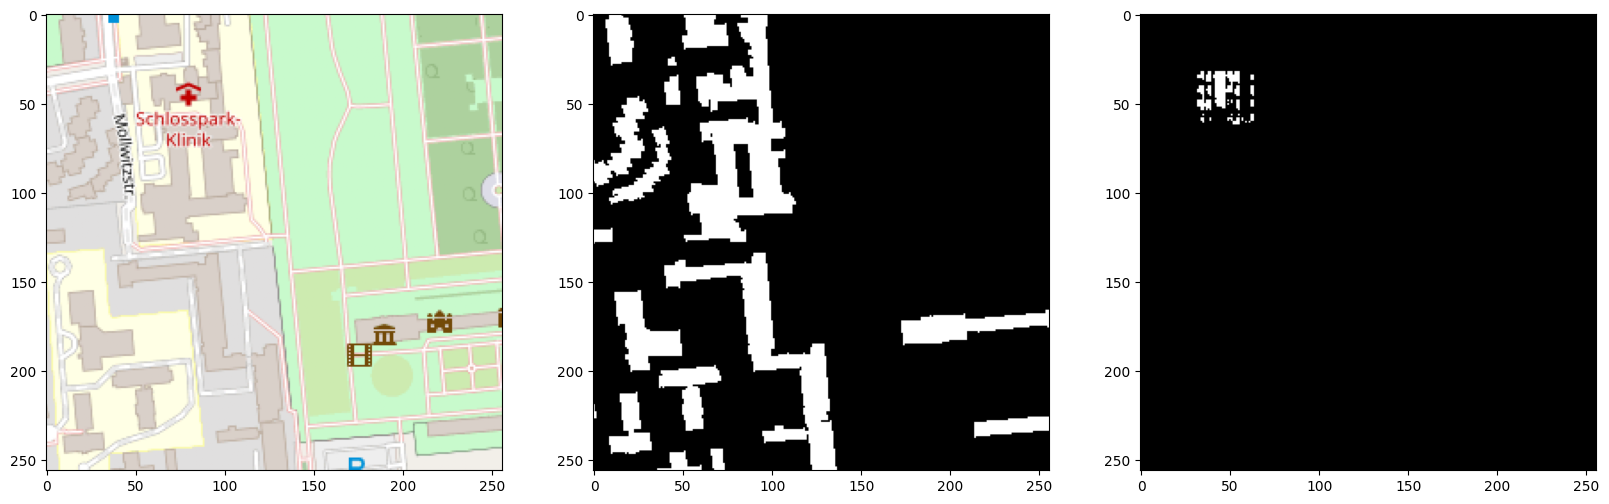

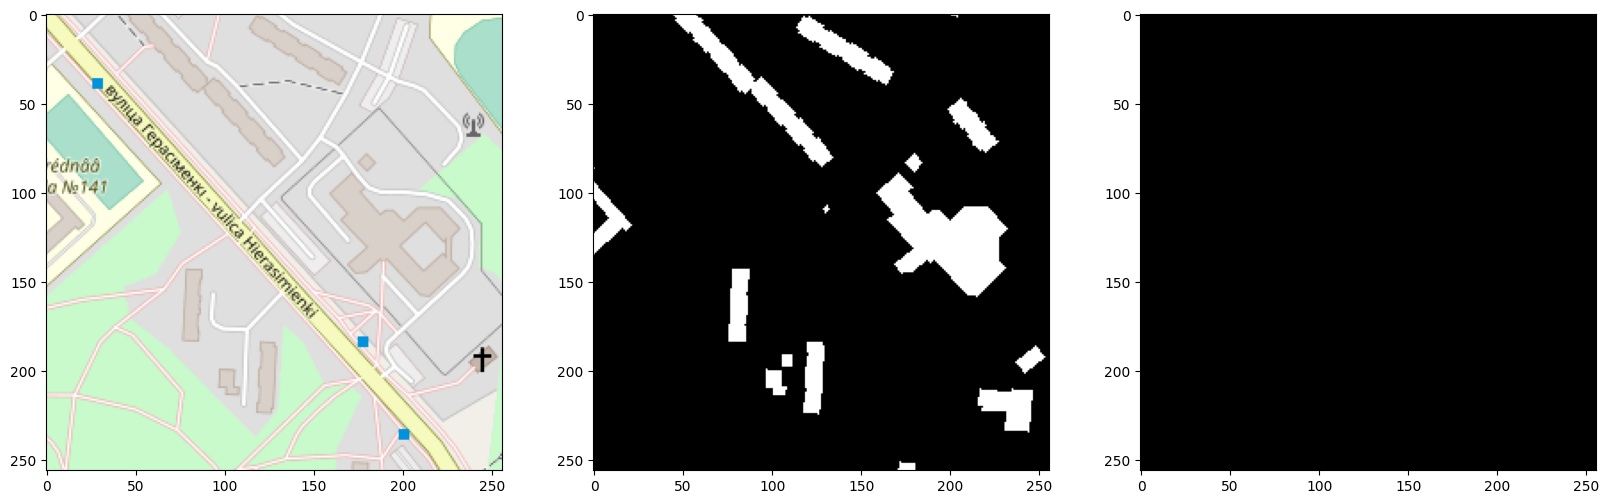

In [44]:
from map_generation.masks.model import Unet

nn = Unet([16, 32, 64, 128, 256], 1)
model = SegmentationModule.load_from_checkpoint("model/segmentation_unet_drop_0.5.ckpt", segmentation_model=SegmentationModel(nn, None))

show_result(test_ds[2001], model)
img_ds = to_tensor(ds[2001]["image"].convert("RGB"))
show_result([img_ds, torch.ones_like(img_ds)], model)
show_result(test_ds[64], model)
show_result(test_ds[202], model)


In [7]:
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

def num_params(model):
    return sum(p.numel() for p in model.parameters())


model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-tiny")
n_h = num_params(model)


In [6]:
from map_generation.masks.model import Unet

nn = Unet([16, 32, 64, 128, 256], 1)
n_u = num_params(nn)

In [5]:
weights = FCN_ResNet50_Weights.DEFAULT
fcn = fcn_resnet50(weights=weights)
n_fcn = num_params(fcn)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /home/marcin/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:44<00:00, 3.18MB/s] 


In [16]:
import pandas as pd

df = pd.DataFrame([n_h, n_u, n_fcn], )

df

,0
upernet,60242636
unet,1331729
fcn,35322218


In [29]:
df = pd.DataFrame(
    df.to_numpy() / df.T.to_numpy(),
    columns=["n / n_upernet_params", "n / n_unet_params", "n / n_fcn_params"],
    index=["upernet", "unet", "fcn"],
)
df

,n / n_upernet_params,n / n_unet_params,n / n_fcn_params
upernet,1.000000,45.236408,1.705517
unet,0.022106,1.000000,0.037702
fcn,0.586333,26.523578,1.000000
